<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Data Analytics 

### Distribution Transformations in Python 


#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Data Analytics: Parametric Distributions

Here's a demonstration of making and general use of parametric distributions in Python. This demonstration is part of the resources that I include for my courses in Spatial / Subsurface Data Analytics at the Cockrell School of Engineering at the University of Texas at Austin.  

#### Parametric Distributions

We will cover the following distributions:

* Uniform
* Triangular
* Gaussian
* Log Normal

We will demonstrate:

* distribution parameters 
* forward and inverse operators
* summary statistics

I have a lecture on these parametric distributions available on [YouTube](https://www.youtube.com/watch?v=U7fGsqCLPHU&t=1687s).   

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - [sample_data.csv](https://github.com/GeostatsGuy/GeoDataSets/blob/master/sample_data.csv).

#### Importing Packages

We will need some standard packages. These should have been installed with Anaconda 3.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # randon numbers
import seaborn as sns                     # matrix scatter plots
from scipy.stats import norm              # Gaussian parametric distribution
from sklearn import preprocessing
import geostatspy.GSLIB as GSLIB
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

#### Set the Random Number Seed

Set the random number seed so that we have a repeatable workflow

In [2]:
seed = 73073

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  For fun try misspelling the name. You will get an ugly, long error.  

In [4]:
df = pd.read_csv('sample_data.csv')     # load our data table (wrong name!)

It worked, we loaded our file into our DataFrame called 'df'. But how do you really know that it worked? Visualizing the DataFrame would be useful and we already leard about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [5]:
df.head(n=6)                           # we could also use this command for a table preview

,X,Y,Facies,Porosity,Perm,AI
0,100.0,900.0,1.0,0.100187,1.363890,5110.699751
1,100.0,800.0,0.0,0.107947,12.576845,4671.458560
2,100.0,700.0,0.0,0.085357,5.984520,6127.548006
3,100.0,600.0,0.0,0.108460,2.446678,5201.637996
4,100.0,500.0,0.0,0.102468,1.952264,3835.270322
5,100.0,400.0,0.0,0.110579,3.691908,5295.267191


#### Calculating and Plotting a CDF by Hand

Let's demonstrate the calculation and plotting of a non-parametric CDF by hand

1. make a copy of the feature as a 1D array (ndarray from NumPy)
2. sort the data in ascending order
3. assign cumulative probabilities based on the tail assumptions
4. plot cumuative probability vs. value

The ndarray has a shape of (261,).


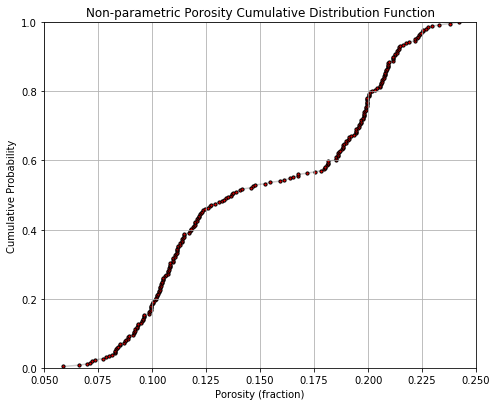

In [6]:
por = df['Porosity'].copy(deep = True).values # make a deepcopy of the feature from the DataFrame
print('The ndarray has a shape of ' + str(por.shape) + '.')

por = np.sort(por)                           # sort the data in ascending order
n = por.shape[0]                             # get the number of data samples

cprob = np.zeros(n)
for i in range(0,n):
    index = i + 1
    cprob[i] = index / n                     # known upper tail
    # cprob[i] = (index - 1)/n               # known lower tail
    # cprob[i] = (index - 1)/(n - 1)         # known upper and lower tails
    # cprob[i] = index/(n+1)                 # unknown tails  

plt.subplot(111)
plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Porosity Cumulative Distribution Function")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.1, hspace=0.2)
plt.show()

#### Transformation to a Parametric Distribution

We can transform our data feature distribution to any parametric distribution with this workflow.

1. Calculate the cumulative probability value of each of our data values, $p_{\alpha} = F_x(x_\alpha)$, $\forall$ $\alpha = 1,\ldots, n$.

2. Apply the inverse of the target parametric cumulative distribution function (CDF) to calculate the transformed values. $y_{\alpha} = G_y^{-1}\left(F_x(x_\alpha)\right)$, $\forall$ $\alpha = 1,\ldots, n$.



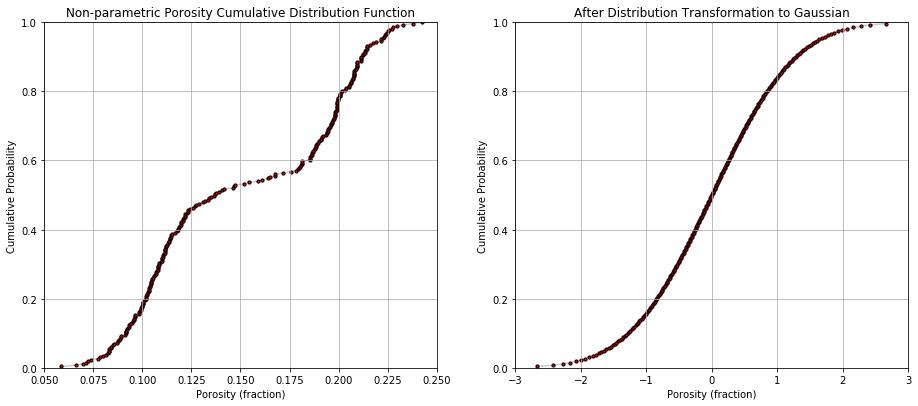

In [7]:
y = np.zeros(n)

for i in range(0,n):
    y[i] = norm.ppf(cprob[i],loc=0.0,scale=1.0)

plt.subplot(121)
plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Porosity Cumulative Distribution Function")

plt.subplot(122)
plt.plot(y,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(y,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([-3.0,3.0]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("After Distribution Transformation to Gaussian")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()
    

Let's make an interactive version of this plot to visualize the transformation.

In [8]:
# widgets and dashboard
l = widgets.Text(value='                                                  Data Analytics, Distribution Transformation, Prof. Michael Pyrcz, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

data_index = widgets.IntSlider(min=1, max = n-1, value=1.0, step = 10.0, description = 'Data Index, $\\alpha$',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)

ui = widgets.VBox([l,data_index],)

def run_plot(data_index):                       # make data, fit models and plot
    plt.subplot(131)
    plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
    plt.scatter(por,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
    plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
    plt.xlabel("Original Feature, $x$"); plt.ylabel("Cumulative Probability"); plt.title("Original Cumulative Distribution Function")
    plt.plot([por[data_index-1],por[data_index-1]],[0.0,cprob[data_index-1]],color = 'red',linestyle='dashed')
    plt.plot([por[data_index-1],3.0],[cprob[data_index-1],cprob[data_index-1]],color = 'red',linestyle='dashed')
    plt.annotate('x = ' + str(round(por[data_index-1],2)), xy=(por[data_index-1]+0.003, 0.01))
    plt.annotate('p = ' + str(round(cprob[data_index-1],2)), xy=(0.225, cprob[data_index-1]+0.02))

    
    plt.subplot(132)
    plt.plot(y,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
    plt.scatter(y,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
    plt.grid(); plt.xlim([-3.0,3.0]); plt.ylim([0.0,1.0])
    plt.xlabel("Gaussian Transformed Feature, $y$"); plt.ylabel("Cumulative Probability"); plt.title("After Distribution Transformation to Gaussian")
    plt.plot([-3.0,y[data_index-1]],[cprob[data_index-1],cprob[data_index-1]],color = 'red',linestyle='dashed')
    plt.plot([y[data_index-1],y[data_index-1]],[0.0,cprob[data_index-1]],color = 'red',linestyle='dashed')
    #plt.arrow(y[data_index-1],cprob[data_index-1],0.0,-1.0*(cprob[data_index-1]-0.01),color = 'red',width = 0.02, head_width = 0.1, linestyle='dashed', head_length = 0.01)
    plt.annotate('p = ' + str(round(cprob[data_index-1],2)), xy=(-2.90, cprob[data_index-1]+0.02)) 
    plt.annotate('y = ' + str(round(y[data_index-1],2)), xy=(y[data_index-1]+0.1, 0.01))
    
    plt.subplot(133)
    plt.plot(por,y, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
    plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([-3.0,3.0])
    plt.xlabel("Original Porosity (fraction)"); plt.ylabel("Gaussian Transformed Porosity (N[fraction])"); plt.title("Parametric Distribution Transformation, Q-Q Plot")
    #plt.plot([0.05,0.25],[0.05,0.25],color = 'red',linestyle='dashed', alpha = 0.4)
    plt.scatter(por[data_index-1],y[data_index-1],s = 50, c = 'red', edgecolor = 'black', alpha = 1.0, zorder=200) # plot the CDF points
    plt.scatter(por,y,s = 20, c = 'red', edgecolor = 'black', alpha = 0.1, zorder=100) # plot the CDF points
   
    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(run_plot, {'data_index':data_index})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

### Interactive Data Analytics Distribution Transformation Demonstration 

#### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

Select any data value and observe the distribution transform by mapping through cumulative probability.

### The Inputs

* **data_index** - the data index from 1 to n in the sorted ascending order

In [9]:
display(ui, interactive_plot)                           # display the interactive plot

Output()

#### Distribution Transform to a Non-Parametric Distribution

We can apply the mapping through cumulative probabilities to transform from any distribution to any other distribution.

* let's make a new data set by randomly sampling from the previous one and adding error

Then we can demonstrate transforming this dataset to match the original distribution

* this is mimicking the situation where we transform a dataset to match the distribution of a better sampled analog distribution


The sample ndarray has a shape of (30,).


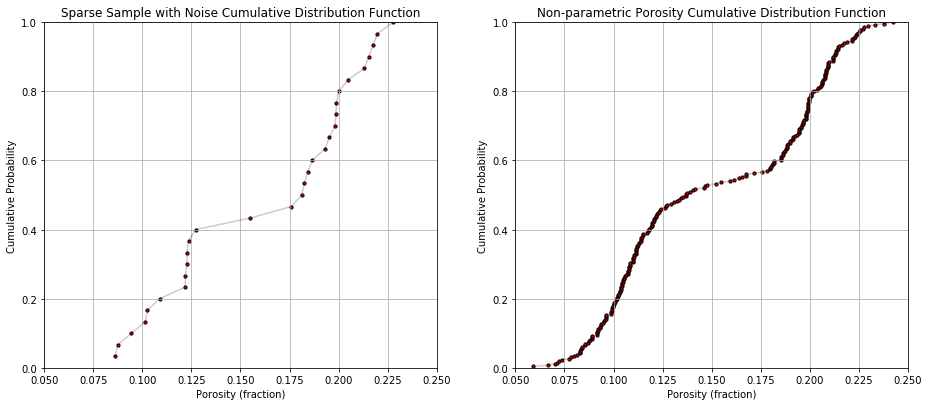

In [10]:
n_sample = 30
df_sample = df.sample(n_sample,random_state = seed)
                      
df_sample = df_sample.copy(deep = True) # make a deepcopy of the feature from the DataFrame

df_sample['Porosity'] = df_sample['Porosity'].values + np.random.normal(loc = 0.0, scale = 0.01, size = n_sample)

df_sample = df_sample.sort_values(by = 'Porosity')                # sort the DataFrame
por_sample = df_sample['Porosity'].values
print('The sample ndarray has a shape of ' + str(por_sample.shape) + '.')

cprob_sample = np.zeros(n_sample)
for i in range(0,n_sample):
    index = i + 1
    cprob_sample[i] = index / n_sample       # known upper tail
    # cprob[i] = (index - 1)/n               # known lower tail
    # cprob[i] = (index - 1)/(n - 1)         # known upper and lower tails
    # cprob[i] = index/(n+1)                 # unknown tails  

plt.subplot(121)
plt.plot(por_sample,cprob_sample, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por_sample,cprob_sample,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Sparse Sample with Noise Cumulative Distribution Function")

plt.subplot(122)
plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Porosity Cumulative Distribution Function")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Let's transform the values and show them on the target distribution.

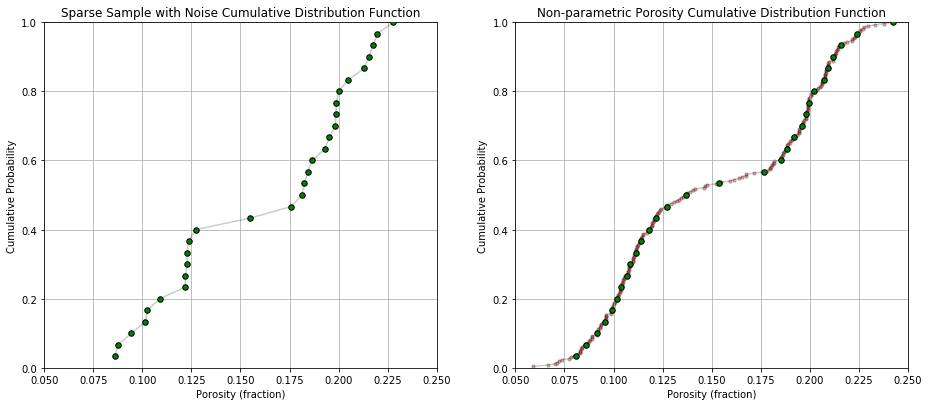

In [11]:
y_sample = np.zeros(n_sample)

for i in range(0,n_sample):
    y_sample[i] = np.percentile(por,cprob_sample[i]*100, interpolation = 'linear') # piecewise linear interpolation of inverse of target CDF 
    
plt.subplot(121)
plt.plot(por_sample,cprob_sample, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por_sample,cprob_sample,s = 30, alpha = 1.0, c = 'green', edgecolor = 'black', zorder = 100) # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Sparse Sample with Noise Cumulative Distribution Function")

plt.subplot(122)
plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por,cprob,s = 10, c = 'red', edgecolor = 'black', alpha = 0.3) # plot the CDF points
plt.scatter(y_sample,cprob_sample,s = 30, c = 'green', edgecolor = 'black', alpha = 1.0, zorder = 100) # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Porosity Cumulative Distribution Function")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Let's make an interactive version of this plot to visualize the transformation.

In [12]:
# widgets and dashboard
l_sample = widgets.Text(value='                                                  Data Analytics, Distribution Transformation, Prof. Michael Pyrcz, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

data_index_sample = widgets.IntSlider(min=1, max = n_sample, value=1.0, step = 1.0, description = 'Data Sample Index, $\\beta$',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)

ui_sample = widgets.VBox([l_sample,data_index_sample],)

def run_plot_sample(data_index_sample):                       # make data, fit models and plot
    plt.subplot(131)
    plt.plot(por_sample,cprob_sample, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
    plt.scatter(por_sample,cprob_sample,s = 30, alpha = 1.0, c = 'green', edgecolor = 'black',zorder = 100) # plot the CDF points
    plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
    plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Original Sparse Sample with Noise, Cumulative Distribution Function")
    plt.plot([por_sample[data_index_sample-1],por_sample[data_index_sample-1]],[0.0,cprob_sample[data_index_sample-1]],color = 'red',linestyle='dashed')
    plt.plot([por_sample[data_index_sample-1],3.0],[cprob_sample[data_index_sample-1],cprob_sample[data_index_sample-1]],color = 'red',linestyle='dashed')
    plt.annotate('x = ' + str(round(por_sample[data_index_sample-1],2)), xy=(por_sample[data_index_sample-1]+0.003, 0.01))
    plt.annotate('p = ' + str(round(cprob_sample[data_index_sample-1],2)), xy=(0.225, cprob_sample[data_index_sample-1]+0.02))
    
    plt.subplot(132)
    plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
    plt.scatter(por,cprob,s = 10, c = 'red', edgecolor = 'black', alpha = 1.0) # plot the CDF points
    plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
    plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Target Porosity Cumulative Distribution Function")
    plt.plot([0.0,y_sample[data_index_sample-1]],[cprob_sample[data_index_sample-1],cprob_sample[data_index_sample-1]],color = 'red',linestyle='dashed')
    plt.plot([y_sample[data_index_sample-1],y_sample[data_index_sample-1]],[0.0,cprob_sample[data_index_sample-1]],color = 'red',linestyle='dashed')
    plt.annotate('p = ' + str(round(cprob_sample[data_index_sample-1],2)), xy=(0.053, cprob_sample[data_index_sample-1]+0.02)) 
    plt.annotate('y = ' + str(round(y_sample[data_index_sample-1],2)), xy=(y_sample[data_index_sample-1]+0.003, 0.01))
    plt.scatter(y_sample[data_index_sample-1],cprob_sample[data_index_sample-1],s = 50, c = 'green', edgecolor = 'black', alpha = 1.0, zorder=100) # plot the CDF points
    
    plt.subplot(133)
    plt.plot(por_sample,y_sample, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
    plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.05,0.25])
    plt.xlabel("Original Porosity (fraction)"); plt.ylabel("Transformed Porosity (fraction)"); plt.title("Non-parametric Distribution Transformation, Q-Q Plot")
    plt.plot([0.05,0.25],[0.05,0.25],color = 'red',linestyle='dashed', alpha = 0.4)
    plt.scatter(por_sample[data_index_sample-1],y_sample[data_index_sample-1],s = 50, c = 'green', edgecolor = 'black', alpha = 1.0, zorder=200) # plot the CDF points
    plt.scatter(por_sample,y_sample,s = 20, c = 'green', edgecolor = 'black', alpha = 0.3, zorder=100) # plot the CDF points
        
    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.show()
    
    
    
# connect the function to make the samples and plot to the widgets    
interactive_plot_s = widgets.interactive_output(run_plot_sample, {'data_index_sample':data_index_sample})
#interactive_plot_sample.clear_output(wait = True)               # reduce flickering by delaying plot updating

### Interactive Data Analytics Distribution Transformation Demonstration 

#### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

Select any data value and observe the distribution transform by mapping through cumulative probability.

#### The Inputs

* **data_index** - the data index from 1 to n in the sorted ascending order

In [13]:
display(ui_sample, interactive_plot_s)                           # display the interactive plot

Output()

To summarize let's look at a DataFrame with the original noisey sample and the transformed to match the original distribution.

* we're making and showing a table of original values, $x_{\beta}$ $\forall$ $\beta = 1, \ldots, n_{sample}$, and the transformed values, $y_{\beta}$ $\forall$ $\beta = 1, \ldots, n_{sample}$.



In [14]:
df_sample['Transformed_Por'] = y_sample
df_sample.head(n=n_sample)

,X,Y,Facies,Porosity,Perm,AI,Transformed_Por
210,231.0,426.0,0.0,0.086204,5.584040,4919.074871,0.081044
3,100.0,600.0,0.0,0.087530,2.446678,5201.637996,0.085867
189,201.0,456.0,0.0,0.094494,0.546396,5018.355476,0.091834
80,900.0,100.0,0.0,0.101609,1.280257,4573.656072,0.095628
207,201.0,426.0,0.0,0.102642,0.400658,5263.542112,0.099378
226,211.0,396.0,0.0,0.108917,6.368529,5725.334803,0.101987
47,600.0,700.0,0.0,0.121845,12.384496,3595.586977,0.103970
72,900.0,900.0,0.0,0.121946,12.433996,6242.704810,0.106704
5,100.0,400.0,0.0,0.122705,3.691908,5295.267191,0.108460
41,500.0,400.0,0.0,0.122854,6.312198,5515.918646,0.111491


It would be straitforward to modify the code above to perform distribution transformations:

* to a parametric distribution like Gaussian

* to a non-parametric distribution from actual data (build a CDF and interpolate between the data samples)

#### Comments

This was a basic demonstration of distribution transformations. 

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at [Python Demos](https://github.com/GeostatsGuy/PythonNumericalDemos) and a Python package for data analytics and geostatistics at [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy). 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
